# Maximum Likelihood Estimation

In [1]:
# Import some helper functions (please ignore this!)
from utils import * 

**Context:** At this point, our modeling toolkit is already getting quite expressive. 
1. We can develop simple *predictive models* using *conditional distributions*: we can specify models of the form $p_{A | B}(a | b)$, which allow us to predict the probability that $A = a$ given that $B = b$. We do this by specifying a distribution over random variable (RV) $A$, whose parameters are a *function* of $b$.  
2. We can develop simple *generative models* using *joint distributions*: we can specify models of the form $p_{A, B}(a, b)$, which allow us to sample (or generate) data. We do this by factorizing this joint probability into a product of conditional and marginal distributions, e.g. $p_{A, B}(a, b) = p_{A | B}(a | b) \cdot p_B(b)$, which we already know how to specify.

Of course, the predictive and generative models you may have heard about in the news are capable of doing more than the instances we've covert so far---we will build up to these fancy models over the course of the semester. What's important for now, though, is that you understand how such models can be represented using probability distributions. 

**Challenge:** So what stands in our way of applying our modeling tools to real-world data? First, we've only instantiated our models with *discrete* distributions. Many real-world data, however, requires *continuous* distributions; that is, distributions over real numbers (e.g. blood pressure, body-mass index, time spent in REM sleep, etc.). We'll get more into the details of continuous modeling a bit later. Our second obstacle is: we still don't have a way of *automatically* fitting a model to data. So far, you've fit all models to data by hand via inspection---you looked at the data and tried to match the model to the data. With increasing model and data complexity, it becomes prohibitively difficult to fit the model to the data by hand. Today, we'll introduce one technique for doing this: maximum likelihood estimation (MLE). The idea behind MLE is to find a model under which the probability of the data is highest. 

**Outline:**
* Formally introduce and motivate the MLE.
* Extend notation of directed graphical models to represent a full data-set instead of just one observation.
* Implement MLE in `NumPyro`.

Let's load our IHH ER data again so we remember what we're working with:

In [2]:
# Import a bunch of libraries we'll be using below
import pandas as pd
import matplotlib.pylab as plt
import numpyro
import numpyro.distributions as D
import jax
import jax.numpy as jnp

# Load the data into a pandas dataframe
csv_fname = 'data/IHH-ER.csv'
data = pd.read_csv(csv_fname, index_col='Patient ID')

# Print a random sample of 5 patients, just to see what's in the data
data.sample(15, random_state=0)

,Day-of-Week,Condition,Hospitalized,Antibiotics,Attempts-to-Disentangle
Patient ID,,,,,
9394,Friday,Allergic Reaction,No,No,NaN
898,Sunday,Allergic Reaction,Yes,Yes,NaN
2398,Saturday,Entangled Antennas,No,No,4.0
5906,Saturday,Allergic Reaction,No,No,NaN
2343,Monday,High Fever,Yes,No,NaN
8225,Thursday,High Fever,Yes,No,NaN
5506,Tuesday,High Fever,No,No,NaN
6451,Thursday,Allergic Reaction,No,No,NaN
2670,Sunday,Intoxication,No,No,NaN


## MLE: Notation and Formalism

The idea behind the MLE is to find the model parameters that maximize the probability of the data. Let's introduce some notation to help us formalize what this means mathematically.

**Notation for Data.** Let $\mathcal{D}$ denote our *all* of our observed data ($\mathcal{D}$ represents the entirety of the above table). Let $\mathcal{D}_n$ represent observation number $n$ (i.e. row $n$) from the table. $\mathcal{D}_n$ is a tuple of values at each of the columns: $\mathcal{D}_n = (D_n, C_n, H_n, A_n, M_n)$. Recall that we define:
* $D$: Day-of-Week	
* $C$: Condition	
* $H$: Hospitalized	
* $A$: Antibiotics
* $M$: Attempts-to-Disentangle

**Notation for Parameters.** For simplicity, we've omitted the notation for each distribution's parameters from the notation so far. From now on, we'll explicitly write out the parameters as arguments to the distribution by listing them after a semi-colon. 
> For example, we can denote that a joint distribution over RVs $A$ and $B$ depends on a parameter $\theta$ as follows: $p_{A, B}(a, b; \theta)$. Similarly, we can write a conditional that depends on $\theta$ using $p_{A | B}(A | B; \theta)$.
>
> If different components of the distribution depend on different parameters, we can list them. For example, in a joint distribution over $A$ and $B$, we can have the conditional depend on $\theta$ and the marginal depend on $\phi$: $p_{A, B}(a, b; \theta, \phi) = p_{A | B}(a | b; \theta) \cdot p_B(b; \phi)$. 

**The MLE Objective.**
Let $\theta$ denote the set of all parameters used in our model for the IHH ER data. Using the above notation, $p_{D, C, H, A, M}(\mathcal{D}; \theta)$ denotes the probability of the observed data. Our goal is then to find the parameters $\theta$ that maximize the probability of having observed $\mathcal{D}$:
\begin{align}
\theta^\text{MLE} &= \mathrm{argmax}_{\theta} \quad p_{D, C, H, A, M}(\mathcal{D}; \theta),
\end{align}
wherein "argmax" denotes the value of $\theta$ that maximizes the joint probability. So what does it mean to evaluate the probability of the *whole data*, $\mathcal{D}$, under our model, $p_{D, C, H, A, M}$? It means evaluating the *joint distribution of all observations*, $\mathcal{D}_n = (D_n, C_n, H_n, A_n, M_n)$ for every $n \in [1, N]$:
\begin{align}
\theta^\text{MLE} &= \mathrm{argmax}_{\theta} \quad  p_{D, C, H, A, M}(\mathcal{D}; \theta) \\
&= \mathrm{argmax}_{\theta} \quad p_{D, C, H, A, M}(\mathcal{D}_1, \cdots, \mathcal{D}_N; \theta),
\end{align}
where $N$ is the total number of observations. 

Now, recall that every joint distribution can be factorized into a product of conditional and marginal distributions, and that the number of possible factorizations grows unwieldy very quickly with the number of variables. Since the number of variables in this joint distribution is a function of the number of observations, $N$, which is large (e.g. thousands), we need some way to select a reasonable factorization. As typical, we are going to assume that the observations are independent, and identically distributed (i.i.d). This means that one patient coming to the ER does not tell us anything about how likely other patients are to come to the ER. Now, recall that when two RVs are independent, their joint distribution equals a product of their marginals. We can therefore factorize the joint distribution as follows:
\begin{align}
\theta^\text{MLE} &= \mathrm{argmax}_{\theta} \quad  p_{D, C, H, A, M}(\mathcal{D}; \theta) \\
&= \mathrm{argmax}_{\theta} \quad p_{D, C, H, A, M}(\mathcal{D}_1, \cdots, \mathcal{D}_N; \theta) \\
&= \mathrm{argmax}_{\theta} \quad \prod\limits_{n=1}^N p_{D, C, H, A, M}(\mathcal{D}_n; \theta) \\
&= \mathrm{argmax}_{\theta} \quad \prod\limits_{n=1}^N \underbrace{p_{D, C, H, A, M}(D_n, C_n, H_n, A_n, M_n; \theta)}_{\text{We already know how to compute this!}}
\end{align}
We have now arrived at a formula for the joint distribution that we know how to compute---we've even written code to evaluate it in `NumPyro`.

**Numerical Stability:** Notice that since our joint is a discrete probability distribution, it outputs probabilities between 0 and 1: $p_{D, C, H, A, M}(D_n, C_n, H_n, A_n, M_n; \theta) \in [0, 1]$. In other words, it outputs *fractions*. In the above formula, we then multiply these fractions times one another $N$ times. But what happens when you multiply fractions together many times? Answer: the results shrinks towards 0 very quickly (try it yourself!). This is a problem, because our computer can only represent small numbers up to a finite precision. For a large $N$, our computer will round down the answer to $0$, which will prevent us from performing the argmax. Because of this issue, we have to transform our original MLE objective into a problem that a computer can numerically solve. 

We do this by maximizing the $\log$ of the joint probability for two reasons:
1. Logs turn products into sums: $\log X \cdot Y = \log X + \log Y$. Applying this formula to our MLE objective results in a *sum* of fractions, which is numerically stable:
\begin{align}
\log \prod\limits_{n=1}^N p_{D, C, H, A, M}(D_n, C_n, H_n, A_n, M_n; \theta) = \sum\limits_{n=1}^N \log p_{D, C, H, A, M}(D_n, C_n, H_n, A_n, M_n; \theta)
\end{align}
2. But by maximizing the $\log$ of the joint probability instead, will we get the wrong answer? Because the $\log$ function is a *strictly increasing function*, our maxima will remain in the same location. That is:
\begin{align}
\theta^\text{MLE} &= \mathrm{argmax}_{\theta} \quad  \prod\limits_{n=1}^N p_{D, C, H, A, M}(D_n, C_n, H_n, A_n, M_n; \theta) \\
&= \mathrm{argmax}_{\theta} \quad  \sum\limits_{n=1}^N \log p_{D, C, H, A, M}(D_n, C_n, H_n, A_n, M_n; \theta)
\end{align}
To illustrate point (2), check out the graph below, which shows that the argmax of a function doesn't change if a $\log$ is applied to it.

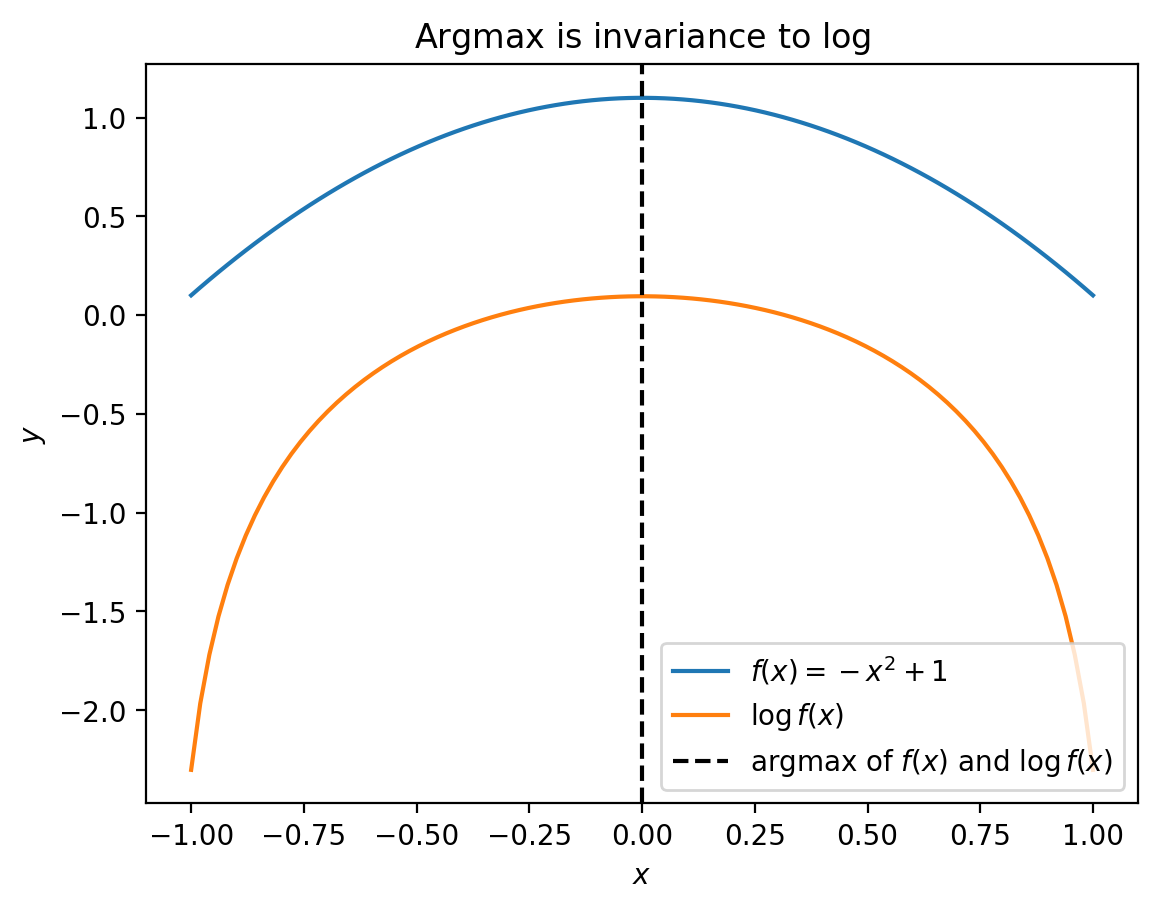

In [3]:
plot_invariance_of_argmax_under_log()

## "Plate Notation" for Directed Graphical Models

* Introduce statistical independence (between observations)
* Introduce graphical representation

## MLE in `NumPyro`

* Vectorization in NumPyro distributions
* NumPyro primitives
* Implement model in NumPyro